# Tutorial 4

## Artificial Neural Networks

An artificial neural network (ANN) is a deterministic map $F: \mathcal{X} \rightarrow \mathcal{Y}$ from features to outputs.

The transformations used inside the ANN are:
\begin{equation*}
\begin{split}
    h_{j}^{(1)} &= a^{(1)} \Big( w_{j}^{(1)} x + b_{j}^{(1)} \Big) \\
    h_{j}^{(i)} &= a^{(i)} \Big( w_{j}^{(i)} h_{j}^{(i-1)} + b_{j}^{(i)} \Big) \\
    y &= f \Big( w_{j} h_{j}^{(L)} + b_{j} \Big)
\end{split}
\end{equation*}
with activation functions $a^{(i)},f$, weights $w_{j}$ and biases $b_{j}$. ANNs can be multidimensional, use different activation functions, have other hyperparameters, etc. 

We can train an ANN (i.e. the tunable parameters $w_{j},b_{j}$) for different tasks, e.g. classification, prediction, clustering, etc., by using different loss criteria.

#### Example: Training of a multi-layer neural network

Full example is available on the [Multi-Layer ANN Example Python notebook by Sebastian Jaimungal](https://github.com/sebjai/STA2536/blob/master/ANN_Basics/Multi-Layer%20ANN%20Example.ipynb). In this class, we use [PyTorch](https://pytorch.org/) to generate neural networks, but there exists other Python libraries to create such structures, e.g. [TensorFlow](https://www.tensorflow.org/).

In [1]:
import numpy as np

import matplotlib.pyplot as plt 


import torch # PyTorch library
import torch.nn as nn # all layers
import torch.nn.functional as F # all activation functions
import torch.optim as optim # all optimization procedures

We first define a class to create generic neural networks with arbitrary structures, and then initialize a single instance.

In [2]:
class MyNet(nn.Module):
    # constructor
    def __init__(self, nInputs, nNodes, nLayers, nOutputs):
        super(MyNet, self).__init__()
        
        # single input layer
        self.prop_in_to_h = nn.Linear(nInputs, nNodes)
        
        # nLayers-1 hidden layers
        self.props_h_to_h = nn.ModuleList([nn.Linear(nNodes, nNodes) for i in range(nLayers-1)])
        
        # single output layer
        self.prop_h_to_out = nn.Linear(nNodes, nOutputs)

    def forward(self, x):
        
        # input layer with sigmoid as activation function
        h = torch.sigmoid(self.prop_in_to_h(x))
        
        # hidden layers with ReLU as activation function
        for prop in self.props_h_to_h:
            h = torch.relu(prop(h))
        
        # output layer with no activation
        y = self.prop_h_to_out(h)
        
        return y

In [3]:
N_hidden = 100 # number of hidden nodes
N_layers = 3 # number of layers
seed = 1234

# set random seed
torch.manual_seed(seed) # pytorch
np.random.seed(seed) # numpy

net = MyNet(1, N_hidden, N_layers, 1)

Let us try to make the neural network fit the following function:
$$
f_1(x) = \frac{1}{20} \left( \frac{5 \sin(x)}{1 + \exp(-x)} + x^2 - x - 5 \right).
$$

In [4]:
f_1 = lambda x : ( 5*np.sin(x)/(1+np.exp(-x)) + x**2-x-5 ) /20

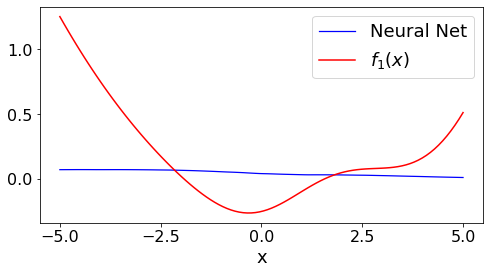

In [5]:
fig, axes = plt.subplots(figsize=(8,5))

# outputs of the neural network
x = torch.tensor( np.expand_dims(np.linspace(-5,5,100), axis=1)).float()
y = net(x)
axes.plot(x.detach().numpy(), y.detach().numpy(),
         color='blue', linewidth=1.25)

# function to learn
x = np.linspace(-5, 5, 100)
axes.plot(x,f_1(x), color='red', linewidth=1.5)

# aesthetics
axes.legend([r'Neural Net',r'$f_1(x)$'], fontsize=18)
axes.set_xlabel(r'x', fontsize=18)
axes.tick_params(axis='both', labelsize=16)
axes.locator_params(axis='both', nbins=5)
plt.tight_layout(pad=5)
plt.show()

We now train the neural network, and plot the progress as the training procedure runs.

In [6]:
def PlotFit(net, f):
    fig, axes = plt.subplots(figsize=(8,5))

    # outputs of the neural network
    x = torch.tensor( np.expand_dims(np.linspace(-5,5,100), axis=1)).float()
    y = net(x)
    axes.plot(x.detach().numpy(), y.detach().numpy(),
             color='blue', linewidth=1.25)

    # function to learn
    x = np.linspace(-5, 5, 100)
    axes.plot(x,f(x), color='red', linewidth=1.5)

    # aesthetics
    axes.legend([r'Neural Net',r'$f(x)$'], fontsize=18)
    axes.set_xlabel(r'x', fontsize=18)
    axes.tick_params(axis='both', labelsize=16)
    axes.locator_params(axis='both', nbins=5)
    plt.tight_layout(pad=5)
    plt.show()

In [7]:
def FitNet(net, f, mini_batch_size, Nepochs):
    
    print(net)
    PlotFit(net, f)
    plt.show()
    
    # create  optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.005)

    loss_hist = []
    
    for epoch in range(Nepochs):  # loop over the dataset multiple times

        # grab a minibatch -- randomize over the range -5 to 5
        x = 10*np.random.rand(mini_batch_size,1)-5
        xt = torch.tensor(x, dtype=torch.float)  

        # the target function
        targets =  f(xt)

        # zero the parameter gradients
        optimizer.zero_grad()

        # push inputs forward through the whole net
        outputs = net(xt)
        
        # compute the loss associated with this output
        loss = torch.mean((outputs-targets)**2)

        # propogate the sensitivity of the output to the model parameters 
        # backwards through the computational graph
        loss.backward()

        # update the weights and biases by taking a SGD step
        optimizer.step()

        # store running loss
        loss_hist.append(  loss.item() )

        # plot output every 100 iterations
        if( ( epoch % 100 == 0) and (epoch > 10) ):
            print(epoch)
            PlotFit(net, f)
            
    print(epoch)
    fig, axes = plt.subplots(figsize=(8,5))
    axes.plot(loss_hist)
    axes.set_title('Loss history', fontsize=22)
    axes.set_xlabel('Number of epochs', fontsize=18)
    axes.set_ylabel('Loss (log scale)', fontsize=18)
    axes.set_yscale('log')
    axes.tick_params(axis='both', labelsize=16)
    plt.tight_layout(pad=2)
    plt.show()

    PlotFit(net, f)

    print('Finished Training')
    
    return loss_hist, net

MyNet(
  (prop_in_to_h): Linear(in_features=1, out_features=100, bias=True)
  (props_h_to_h): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
  )
  (prop_h_to_out): Linear(in_features=100, out_features=1, bias=True)
)


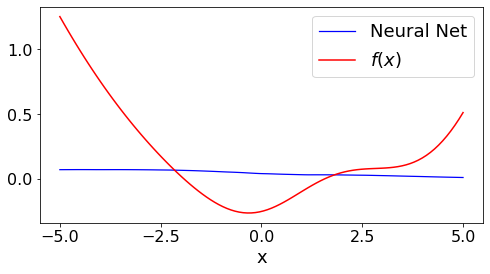

100


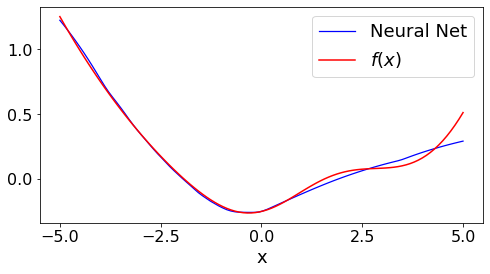

200


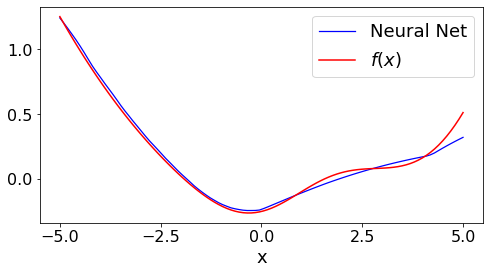

300


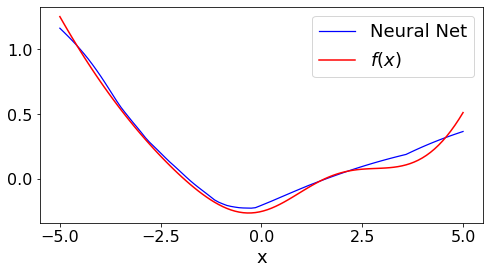

400


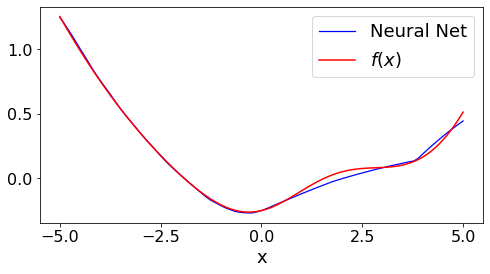

500


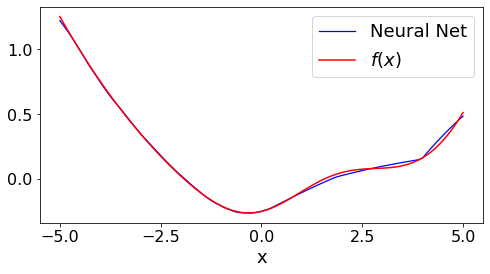

600


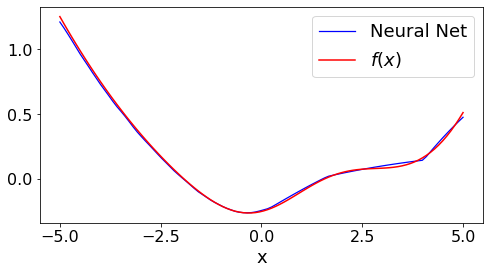

700


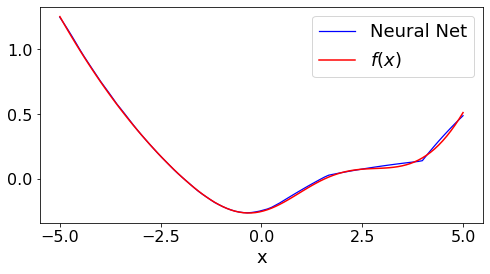

800


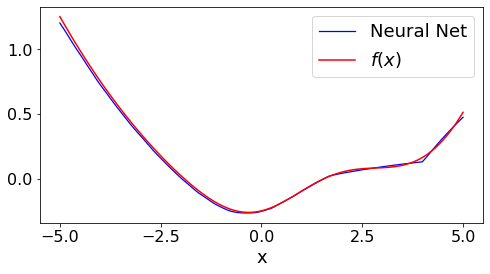

900


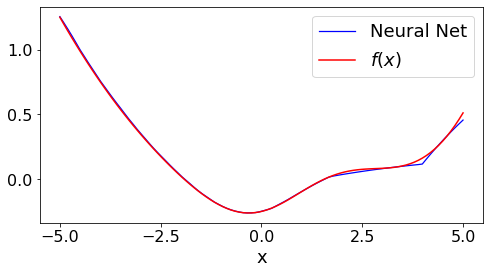

1000


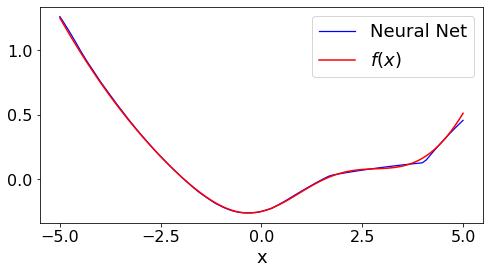

1100


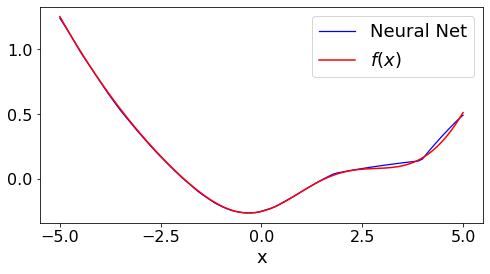

1200


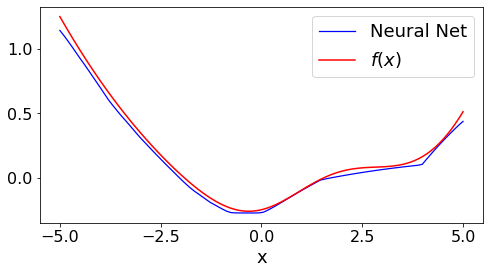

1300


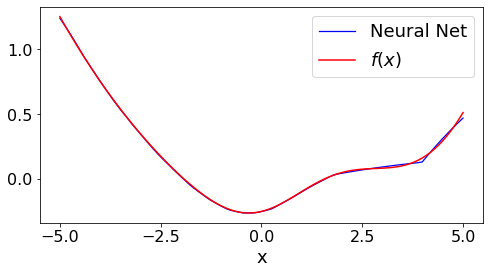

1400


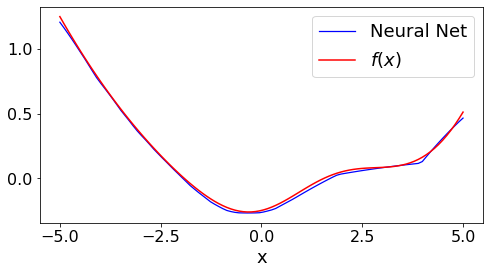

1500


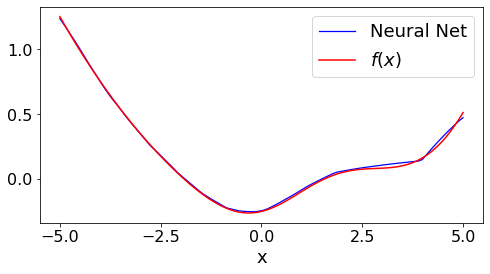

1600


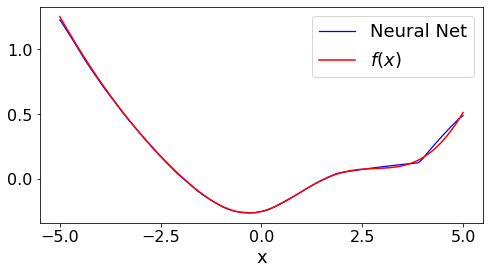

1700


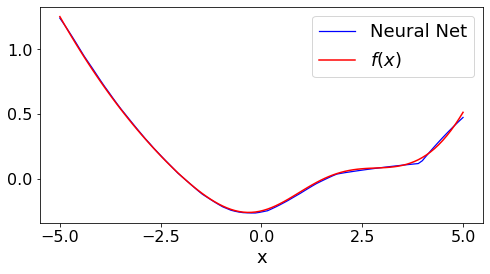

1800


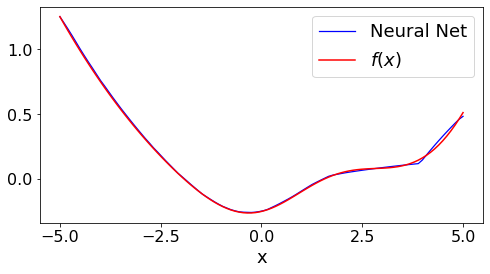

1900


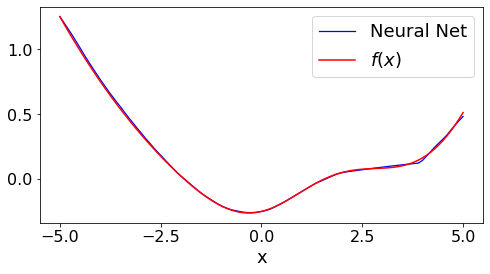

1999


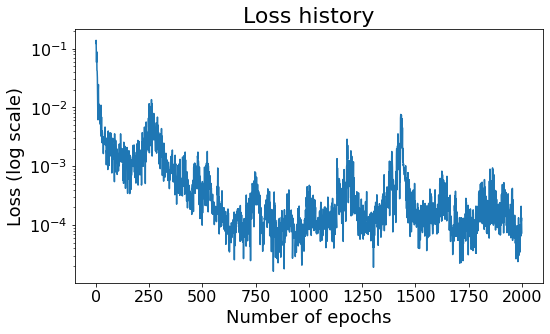

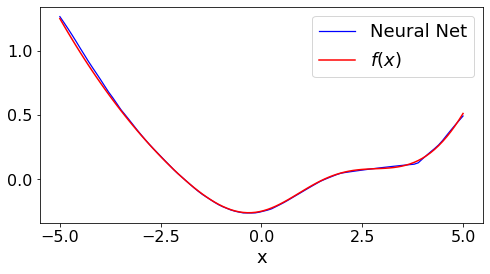

Finished Training


In [8]:
loss_hist, trained_net = FitNet(net, f_1, mini_batch_size=50, Nepochs=2000)